# Lecture 8: Hierarchical models


(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](l08_hierarchical_models.ipynb).*

In [2]:
import numpy as np
import scipy.stats as st

import emcee
import corner

import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

## A sample calculation

We will do MCMC on the hierarchical posterior derived in class for worm reversal data.  Specifically,

\begin{align}
P(q, \kappa,\mathbf{p}\mid \mathbf{r}, \mathbf{n},I) \propto
P(\mathbf{r},\mathbf{n}\mid \mathbf{p}, I)\,
\left(\prod_{i=1}^k P(p_i\mid q,\kappa)\right)\, P(q\mid I)\,P(\kappa\mid I),
\end{align}

where

\begin{align}
P(p_i\mid q, \kappa) =  \frac{\Gamma(\kappa)}{\Gamma(q(\kappa - 2) + 1)\Gamma((1-q)(\kappa - 2) + 1)}\,
p^{q(\kappa - 2)}(1-p)^{(1-q)(\kappa - 2)},
\end{align}

and $p(q\mid I)$ and $p(\kappa\mid I)$ are both constants, defined
respectively on $0\le q \le 1$ and $\kappa > 2$.  As before, we have a
binomial likelihood, where we assume the experiments are independent.

\begin{align}
P(\mathbf{r},\mathbf{n}\mid \mathbf{p}, I) = \prod_{i=1}^k \frac{n_i!}{(n_i-r_i)!r_i!}\,
p_i^{r_i}(1-p_i)^{n_i-r_i}.
\end{align}

To demonstrate how the hierarchical model works, we will consider the two data sets from 2015 and 2016, and an additional three experiments that have 14/40, 5/34, and 110/660 reversals, respectively. The last experiment has many more trials and would dominate pooled data if we were not using a hierarchical model.

In [43]:
# Data
r = np.array([9, 12, 14, 5, 110])
n = np.array([35, 35, 40, 34, 660])

Next, as usual, we define our log posterior.

In [44]:
def log_prior(params):
    """
    Log prior for q (reversal probability) and kappa (concentration).
    This prior is unnormalized.
    """    
    # Unpack
    q = params[0]
    kappa = params[1]
    p = params[2:]
    
    # Within domains?
    if not (0 <= q <= 1) or np.any(p < 0) or np.any(p > 1) or kappa <= 2:
        return -np.inf
    
    # Compute log beta distribution for conditional probability
    alpha = q * (kappa - 2) + 1
    beta = (1 - q) * (kappa - 2) + 1
    return st.beta._logpdf(p, alpha, beta).sum() - np.log(kappa)


def log_likelihood(params, r, n):
    """
    Log likelihood for worm reversal, binomially distributed
    """
    # Unpack
    p = params[2:]

    return st.binom._logpmf(r, n, p).sum()


def log_posterior(params, r, n):
    """
    Log posterior for worm reversals.
    """
    lp = log_prior(params)
    if lp == -np.inf:
        return -np.inf
    return lp + log_likelihood(params, r, n)

Now, we'll do MCMC with this log posterior.

In [66]:
# Set up calculation
n_walkers = 100
n_burn = 1000
n_steps = 1000
p0 = np.empty((n_walkers, 2 + len(r)))
p0[:,0] = np.random.uniform(0, 1, n_walkers)             # q
p0[:,1] = 2 + np.random.exponential(1, n_walkers)        # kappa
p0[:,2:] = np.random.uniform(0, 1, (n_walkers, len(r)))  # p_i's

# Columns for output
columns = ['q', 'kappa'] + ['p' + str(i) for i in range(1, len(r)+1)]

df = bebi103.run_ensemble_emcee(log_posterior, n_burn, n_steps, n_walkers=100, 
                                p0=p0, columns=columns, args=(r, n), threads=6)

Let's make a corner plot to look at the posterior.

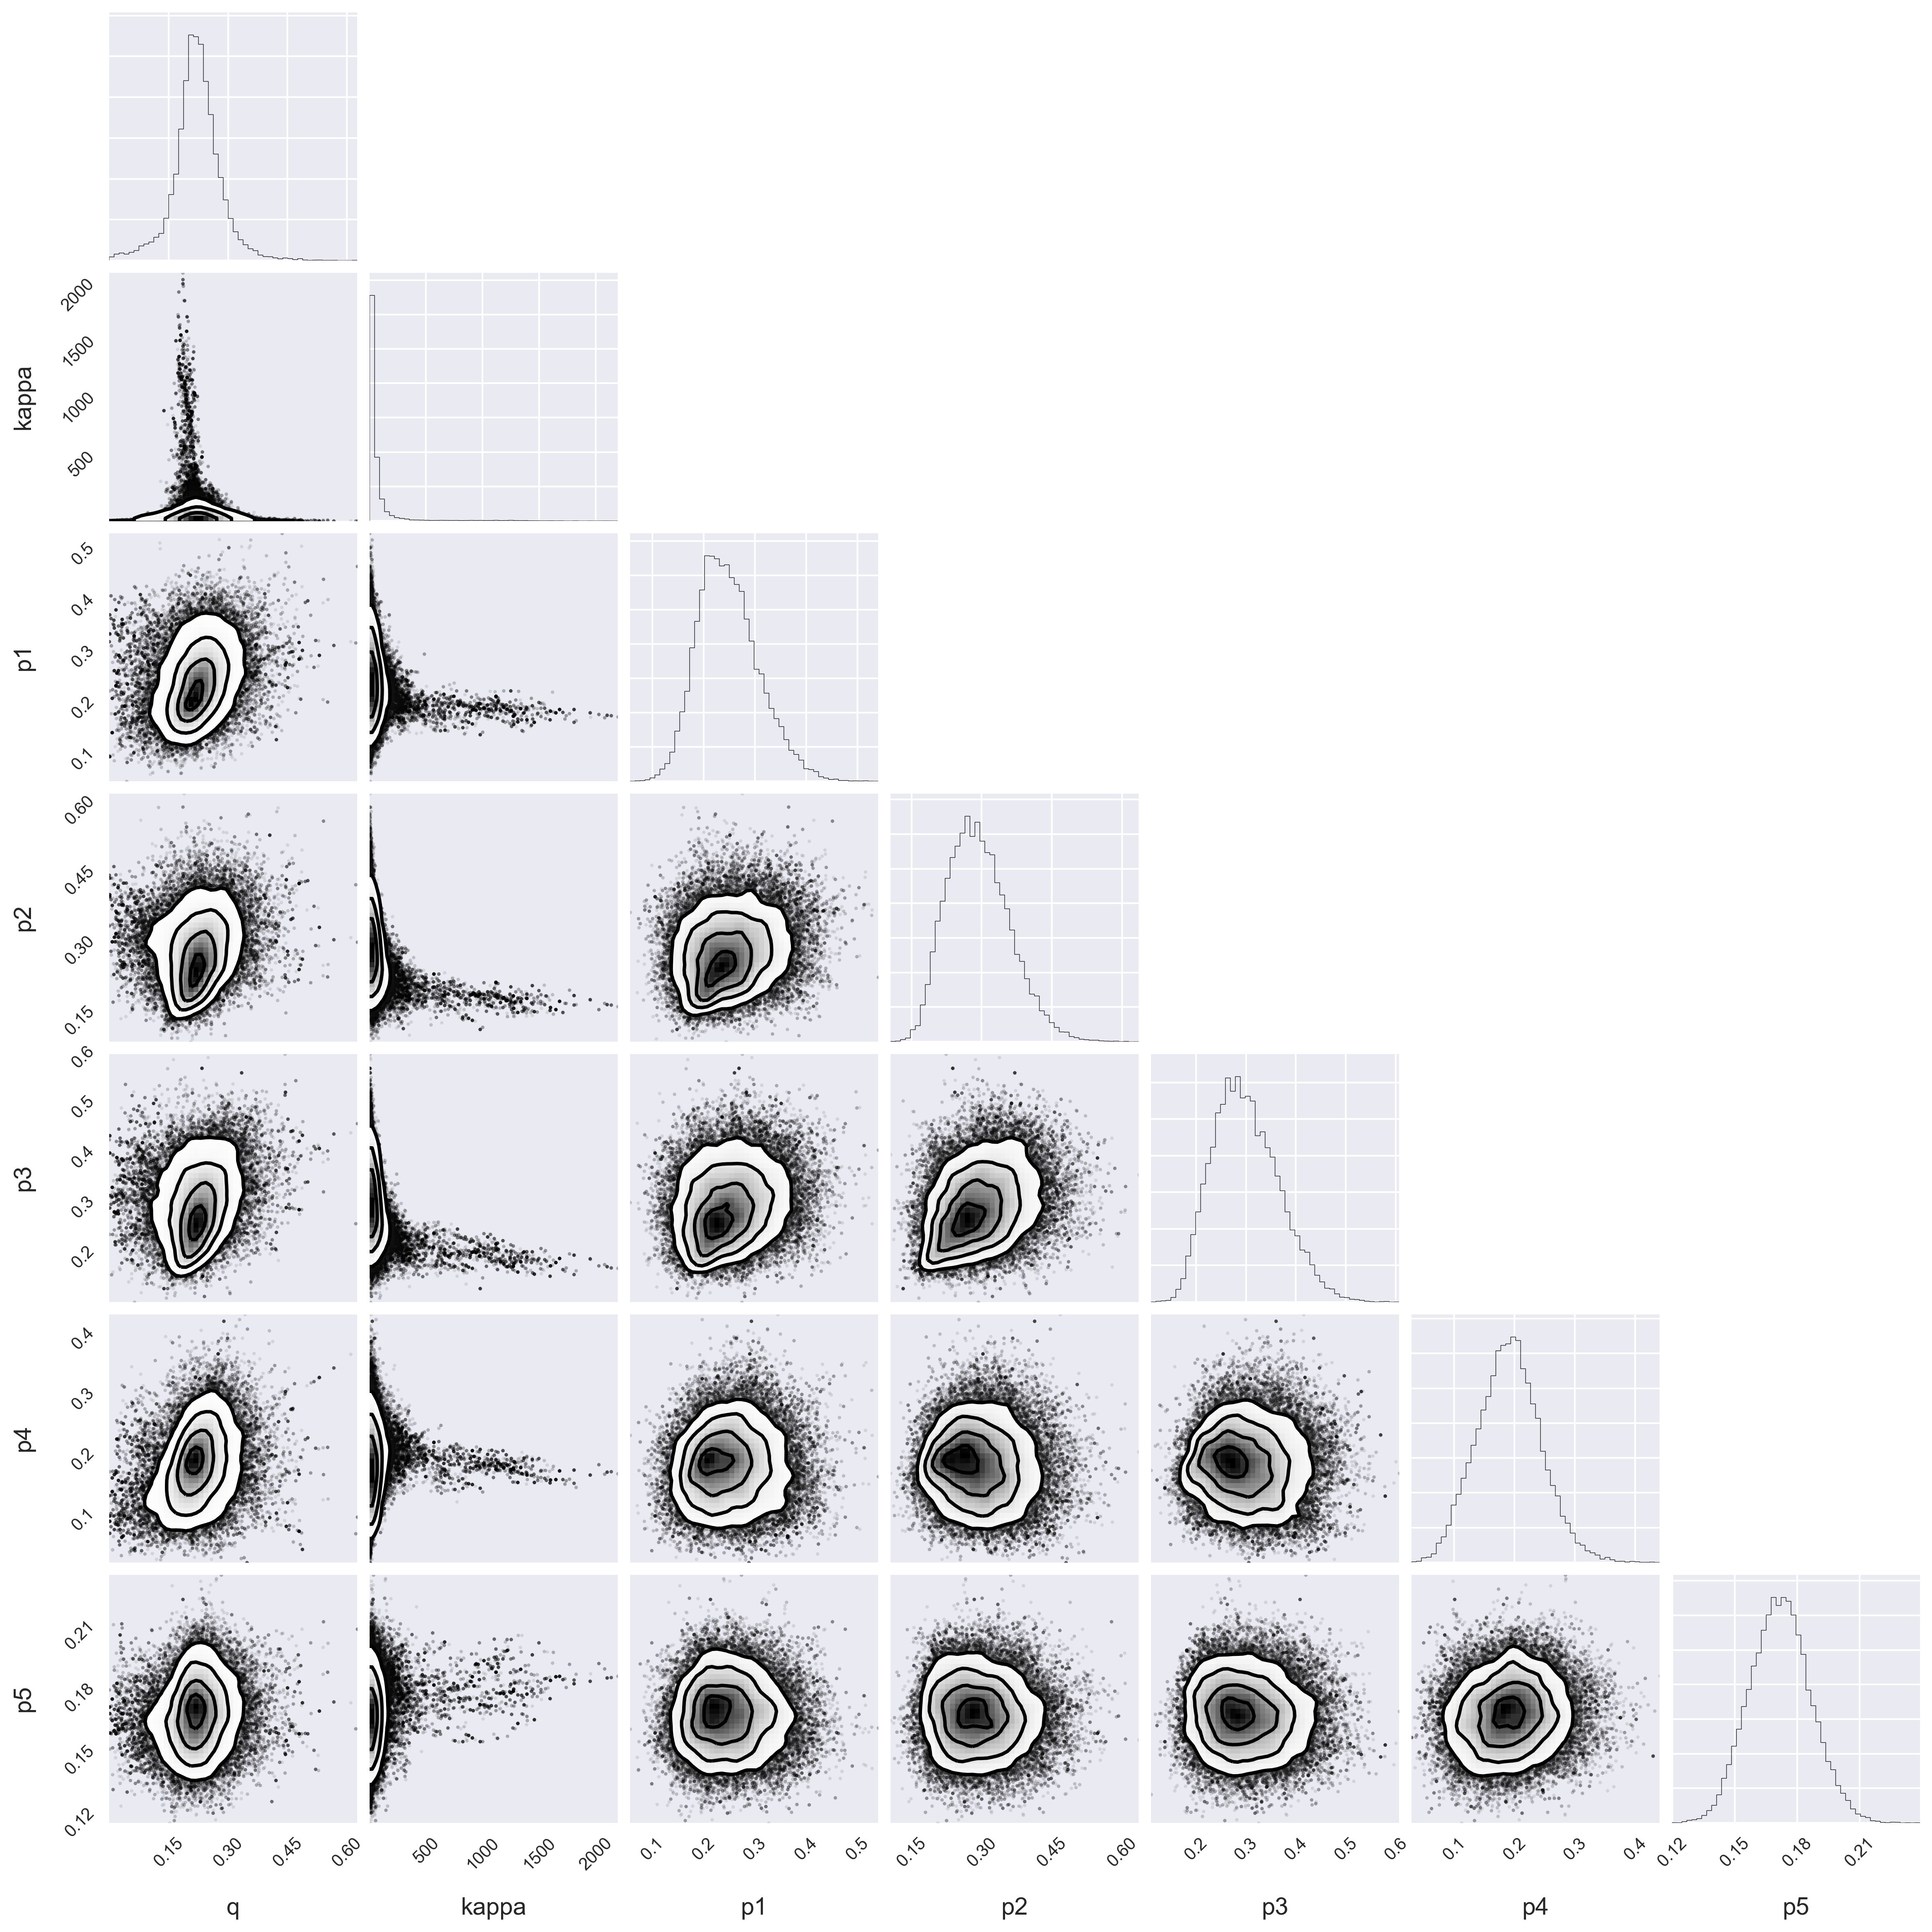

In [67]:
corner.corner(df[columns], bins=50, smooth=1);

We can see the results more clearly if we plot the marginalized distributions on top of each other.  This also allows us to see how the respective experiments serve to determine $q$, the master reversal probability.  We plot the most probable value of $p_i$ in the independent experiment model (i.e., all experiments are independent) as an open circle.  We also plot the more probably reversal probability of the pooled model (all experiments pooled together) as a black open circle.

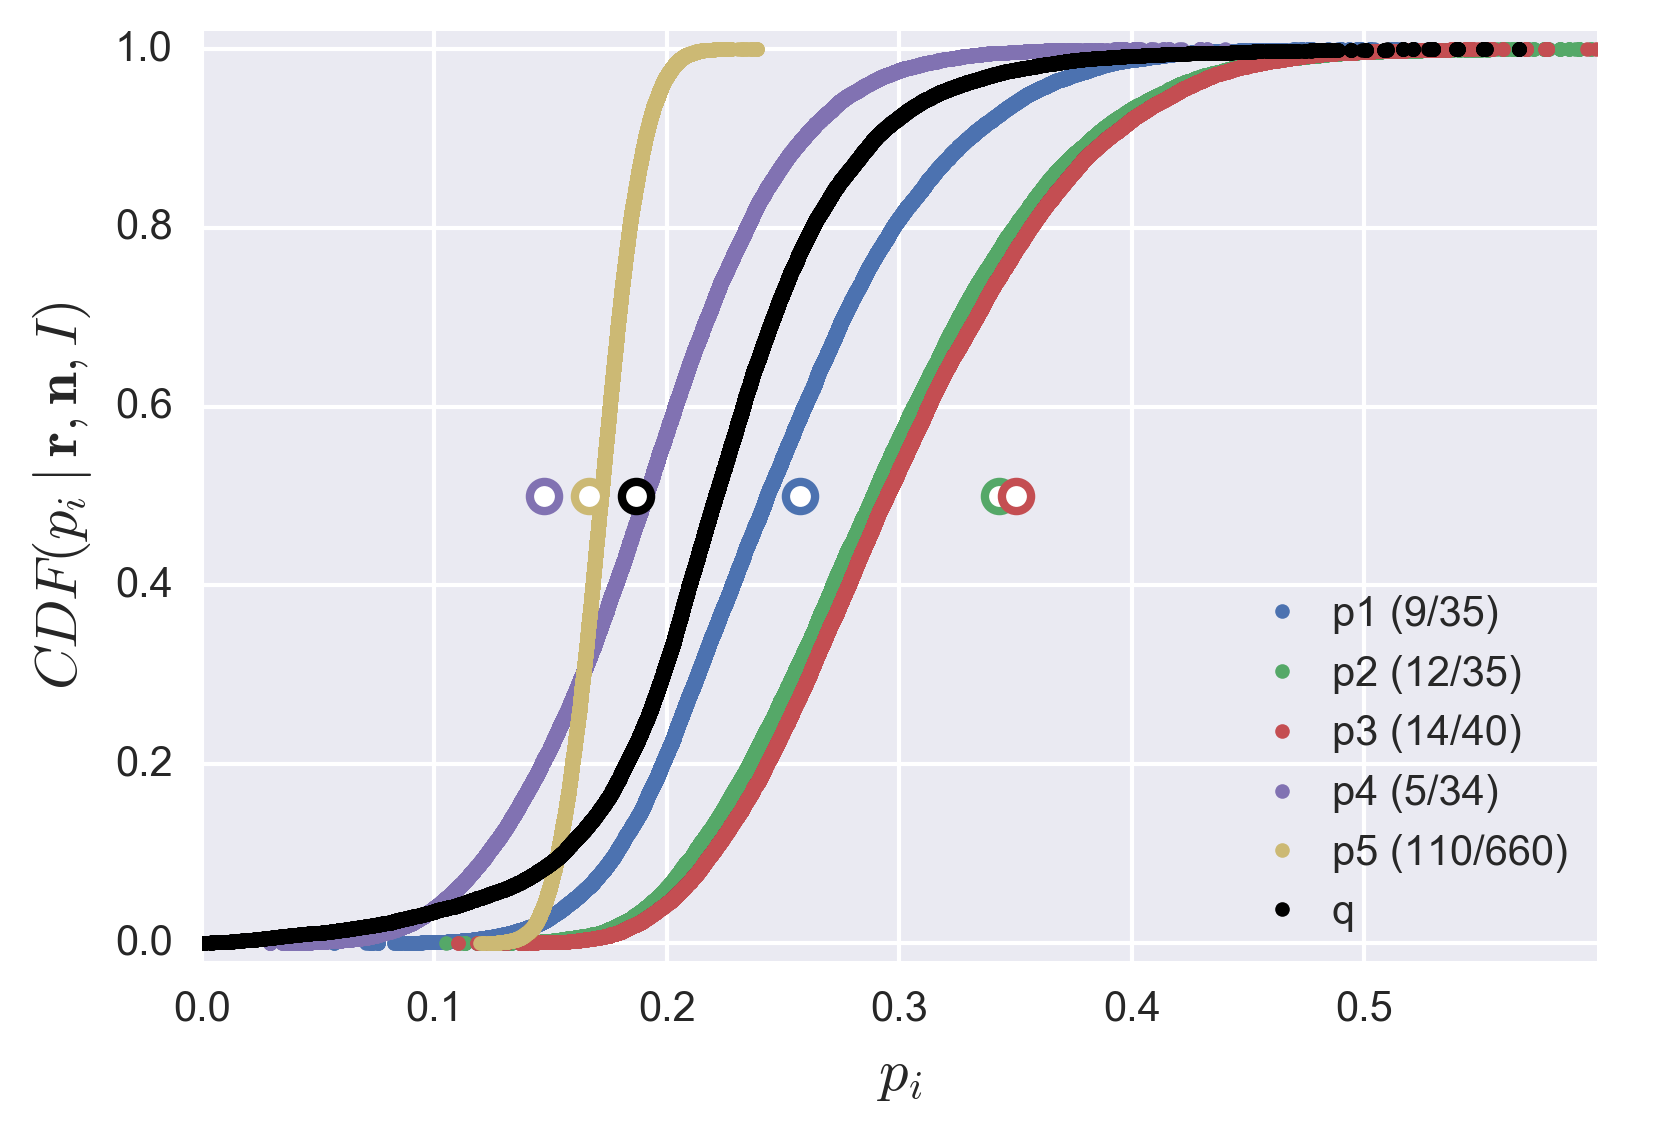

In [68]:
# Plot CDFs for p_i's
for i, p in enumerate(columns[2:]):
    leg_str = 'p{0:d} ({1:d}/{2:d})'.format(i+1, r[i], n[i])
    x, y = bebi103.ecdf(df[p])
    plt.plot(x, y, '.', label=leg_str, color=sns.color_palette()[i])
    plt.plot(r[i]/n[i], 0.5, 'o', mfc='white', mec=sns.color_palette()[i], mew=2)

# Plot q's ECDF
x, y = bebi103.ecdf(df['q'])
plt.plot(x, y, '.', color='black', label='q')
plt.plot(r.sum()/n.sum(), 0.5, 'o', mfc='white', mec='black', mew=2)

# Clean up
plt.xlabel('$p_i$')
plt.ylabel(r'$CDF(p_i\mid \mathbf{r},\mathbf{n},I)$')
plt.legend(loc='lower right')
plt.xlim((0, 0.6))
plt.margins(y=0.02)

We see that the individial parameter values tend to "shrink" toward the hyperparameter value.  The hyperparameter value, in turn, is different than if we pooled all the data together. Notably, the black circle, which represents the most probable value of the reversal probability if we pooled all of the data together, is significantly different than under the hierarchical model. This is because the data set with many more measurements overwhelms the other data sets.

We might be most interested in the hyperparameters, $q$ and $\kappa$.  We already got a plot of their posteriors in the corner plot, and that for $q$ was useful.  We can also compute the most probable $q$ and the 95% HPD.

In [69]:
q = df.loc[np.argmax(df['lnprob']), 'q']
q_hpd = bebi103.hpd(df['q'], 0.95)
print("""
q = [{0:.3f}, {1:.3f}, {2:.3f}]
""".format(q_hpd[0], q, q_hpd[1]))


q = [0.084, 0.192, 0.346]



This makes the longer tail to the left more clear.  This is due to experiment five, which had many samples, but had a low reversal probability.

For understanding how $q$ varies from experiment to experiment (as codified by $\kappa$), it is useful to plot $P(p\mid q, \kappa, I)$ to get a better feel for how $\kappa$ determines the width of the distribution.

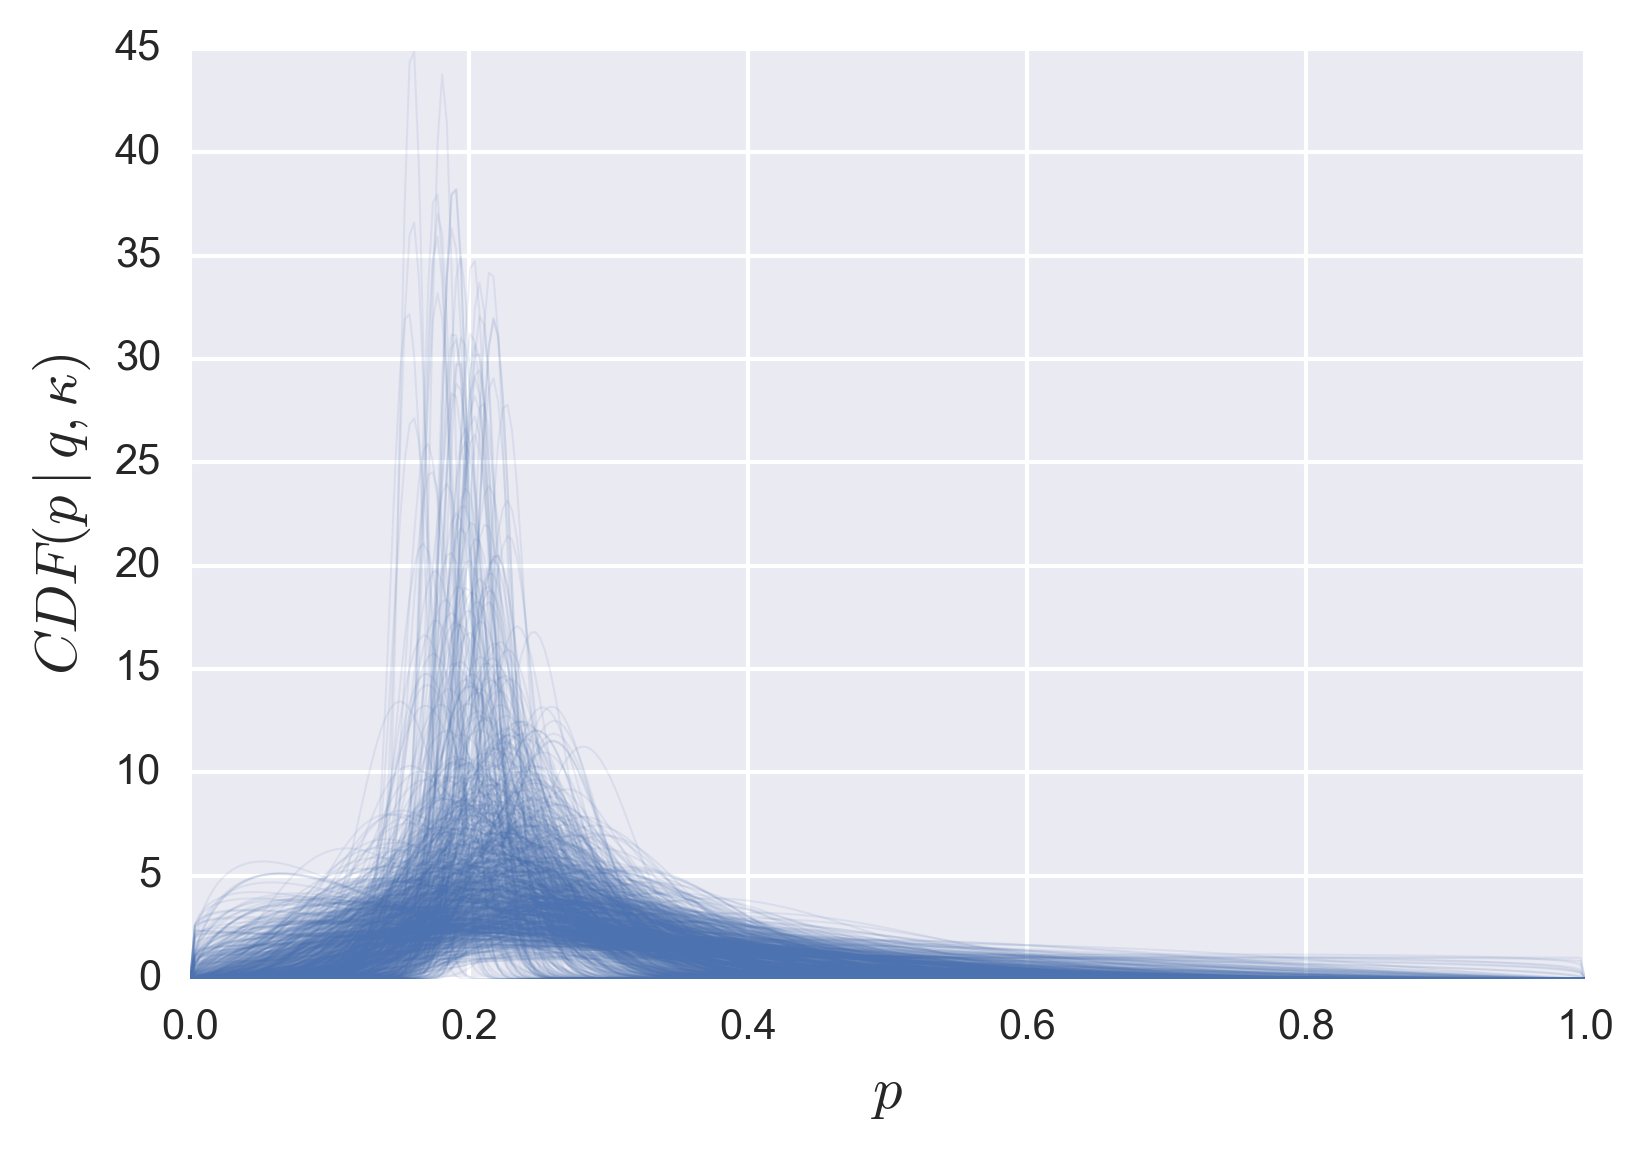

In [65]:
def beta_omega_kappa_pdf(x, omega, kappa):
    """
    Beta distribution parametrized by omega and kappa
    instead of alpha and beta.
    """
    alpha = omega * (kappa - 2) + 1
    beta = (1 - omega) * (kappa - 2) + 1
    return st.beta.pdf(x, alpha, beta)

x = np.linspace(0, 1, 300)
for i in np.random.choice(df.index, 1000):
    plt.plot(x, beta_omega_kappa_pdf(x, df['q'][i], df['kappa'][i]), '-',
             color=sns.color_palette()[0], lw=0.5, alpha=0.1)
    
plt.xlabel('$p$')
plt.ylabel(r'$CDF(p\mid q, \kappa)$');

We get some broad distributions, but also some very sharp ones, centered most often around the most probable $q$ of about 0.2.